## Checking the GPU

In [ ]:
!nvidia-smi

Mon Aug 22 03:39:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Getting the helper functions

In [ ]:
!wget https://raw.githubusercontent.com/r-zeeshan/deep-learning/main/helper_functions.py

--2022-08-22 03:41:42--  https://raw.githubusercontent.com/r-zeeshan/deep-learning/main/my_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12732 (12K) [text/plain]
Saving to: ‘my_helper_functions.py’

my_helper_functions 100%[===================>]  12.43K  --.-KB/s    in 0s      

2022-08-22 03:41:43 (79.3 MB/s) - ‘my_helper_functions.py’ saved [12732/12732]



## Get Tensorflow datasets

In [ ]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## Becoming One with the Data

In [ ]:
# Take one sample of the training data
train_one_sample = train_data.take(1)

for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape}
    Image dtype : {image.dtype}
    Target class : {label}
    Class name : {class_names[label.numpy()]}
    """)


    Image Shape: (512, 512, 3)
    Image dtype : <dtype: 'uint8'>
    Target class : 56
    Class name : huevos_rancheros
    


In [ ]:
import tensorflow as tf
# What are minimum and maximum values of the "image"
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an Image from Tensorflow Dataset

(-0.5, 511.5, 511.5, -0.5)

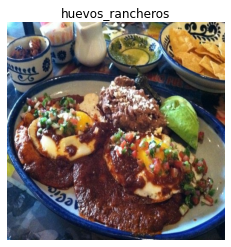

In [ ]:

import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Creating preprocessing functions for our data

In [ ]:
# Making a function for preprocessing images
def preprocess_image(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image,tf.float32), label

(-0.5, 223.5, 223.5, -0.5)

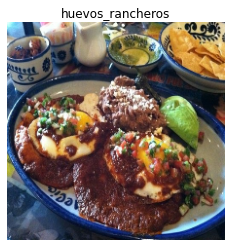

In [ ]:
preprocessed_img = preprocess_image(image, label)[0]
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

## Batch and Prepare Dataset

In [ ]:
# Map preprocessing function on training data (and parallelize it)
train_data = train_data.map(map_func=preprocess_image,
                            num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Map preprocessing function to the test dataset
test_data = test_data.map(map_func=preprocess_image,
                          num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating the modelling callbacks

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Tensorboard Callback
from my_helper_functions import create_tensorboard_callback

# Model Checkpoint Callback
checkpoint_path = "/content/drive/MyDrive/new_model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor="val_accuracy",
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       verbose=0,
                                                      save_freq='epoch')

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Reduce Learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

# Creating callbacks list
callbacks = [early_stopping, reduce_lr, model_checkpoint,
             create_tensorboard_callback("food_vision", "efficientnetb3")]

Saving TensorBoard log files to: food_vision/efficientnetb3/20220822-035226


## Setup Mixed Precision Training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

## Building an EfficientNetB3 Fine Tuning Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB1(include_top=False)
base_model.trainable=True

27033600/27018416 [==============================] - 1s 0us/step


## Creating a food vision model

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.load_weights("/content/drive/MyDrive/model_checkpoints/cp.ckpt")

# Compiling the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

## Checking the summary of my model 

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 output_layer (Activation)   (None, 101)               0         
                                                                 
Total params: 6,704,620
Trainable params: 6,642,565
Non-trainable params: 62,055
____________________________________________

## Fitting the model

In [ ]:
efficientnet_b3_history = model.fit(train_data,
                                    epochs=50,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.1 * len(test_data)),
                                    callbacks=callbacks)

Epoch 1/50
2368/2368 [==============================] - 596s 221ms/step - loss: 0.0422 - accuracy: 0.9892 - val_loss: 0.8121 - val_accuracy: 0.8323 - lr: 2.0000e-04
Epoch 2/50
2368/2368 [==============================] - 535s 225ms/step - loss: 0.0346 - accuracy: 0.9908 - val_loss: 0.8155 - val_accuracy: 0.8291 - lr: 2.0000e-04
Epoch 3/50
2368/2368 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9924
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
2368/2368 [==============================] - 526s 221ms/step - loss: 0.0291 - accuracy: 0.9924 - val_loss: 0.8515 - val_accuracy: 0.8248 - lr: 2.0000e-04
Epoch 4/50
2368/2368 [==============================] - 520s 219ms/step - loss: 0.0185 - accuracy: 0.9954 - val_loss: 0.8096 - val_accuracy: 0.8386 - lr: 4.0000e-05
Epoch 5/50
2368/2368 [==============================] - 522s 220ms/step - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.7958 - val_accuracy: 0.8398 - lr: 4.0000e-05
Epoch 6/50


In [ ]:
model.save("/content/drive/MyDrive/models/eff_net_b1.h5")
model.save("/content/drive/MyDrive/models/eff_net_b1_model")

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 0.8528 - accuracy: 0.8380


[0.8527722954750061, 0.8379802107810974]

In [ ]:
preds = model.predict(test_data)

In [ ]:
from my_helper_functions import make_predictions, get_class_f1_scores, plot_f1_scores, make_confusion_matrix

In [ ]:
def lake_predictions(model, data):
    """
    Makes predictions on the data using the given model.

    Args:
        model (obj) : Trained model
        data (BatchDataset) : Data to make predictions on.

    Returns: 
        y_labels and pred_classes of the given data.

    Example usage:
        make_predictions(model = cnn_model,
                         data = test_data)
    """
    # Make Predictions on test data using the given model
    pred_prob = model.predict(data)

    # Get pred classes of each label
    pred_classes = pred_prob.argmax(axis=1)

    # To get our test labels we need to unravel our test data batch Dataset
    y_labels = []
    for images, labels in data.unbatch():
        y_labels.append(labels.numpy())

    return y_labels, pred_classes

In [ ]:
y_labels, pred_classes = lake_predictions(model, test_data)

In [ ]:
f1_scores = get_class_f1_scores(y_labels, class_names, pred_classes)

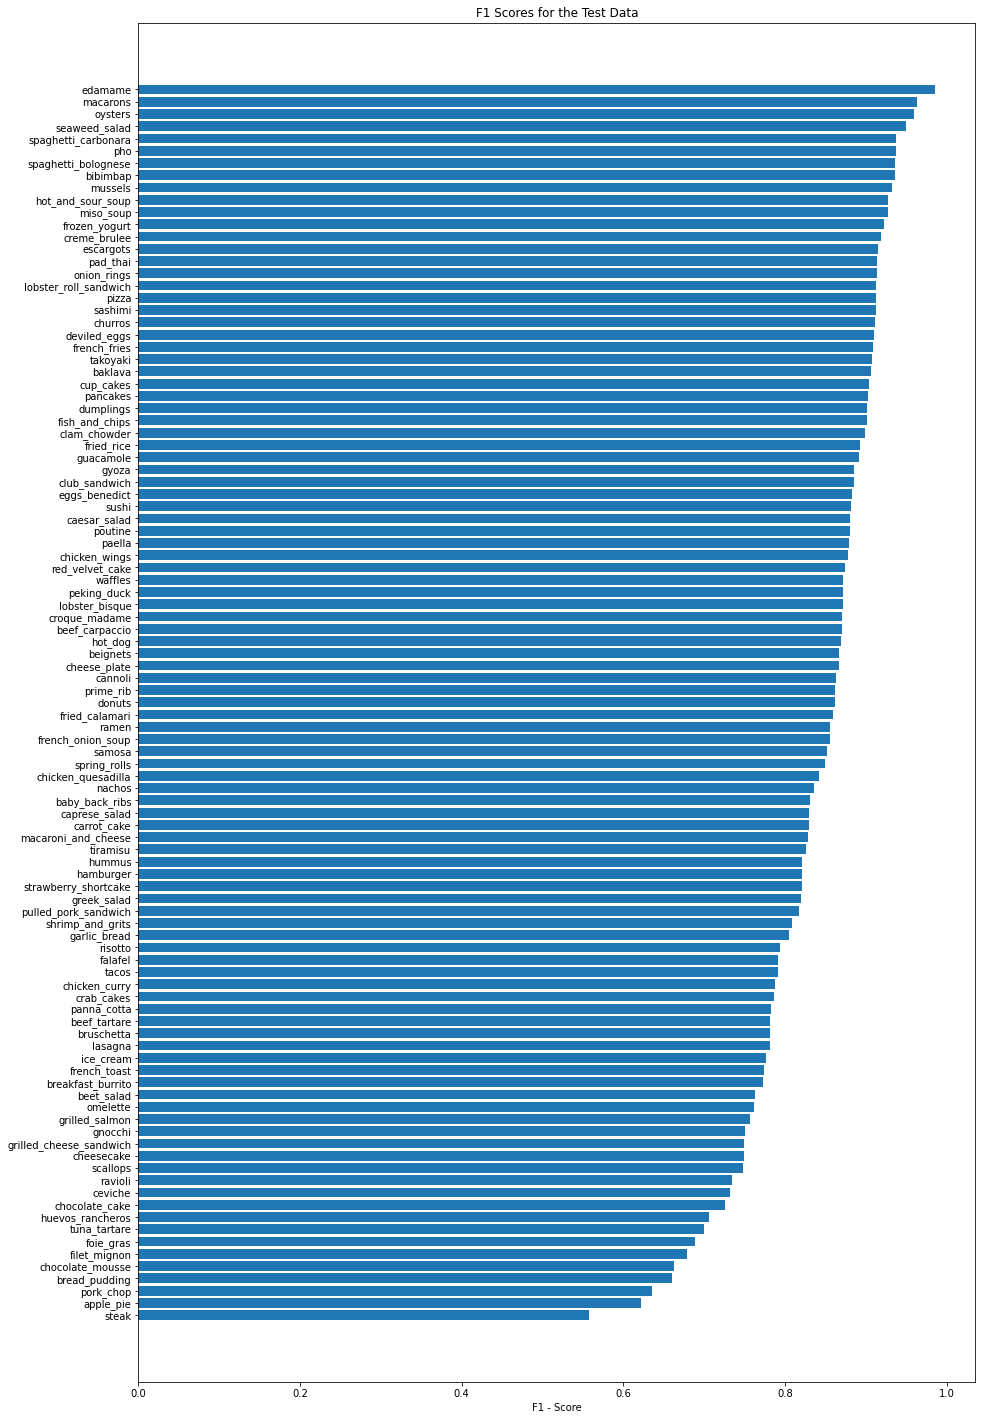

In [ ]:
plot_f1_scores(f1_scores)

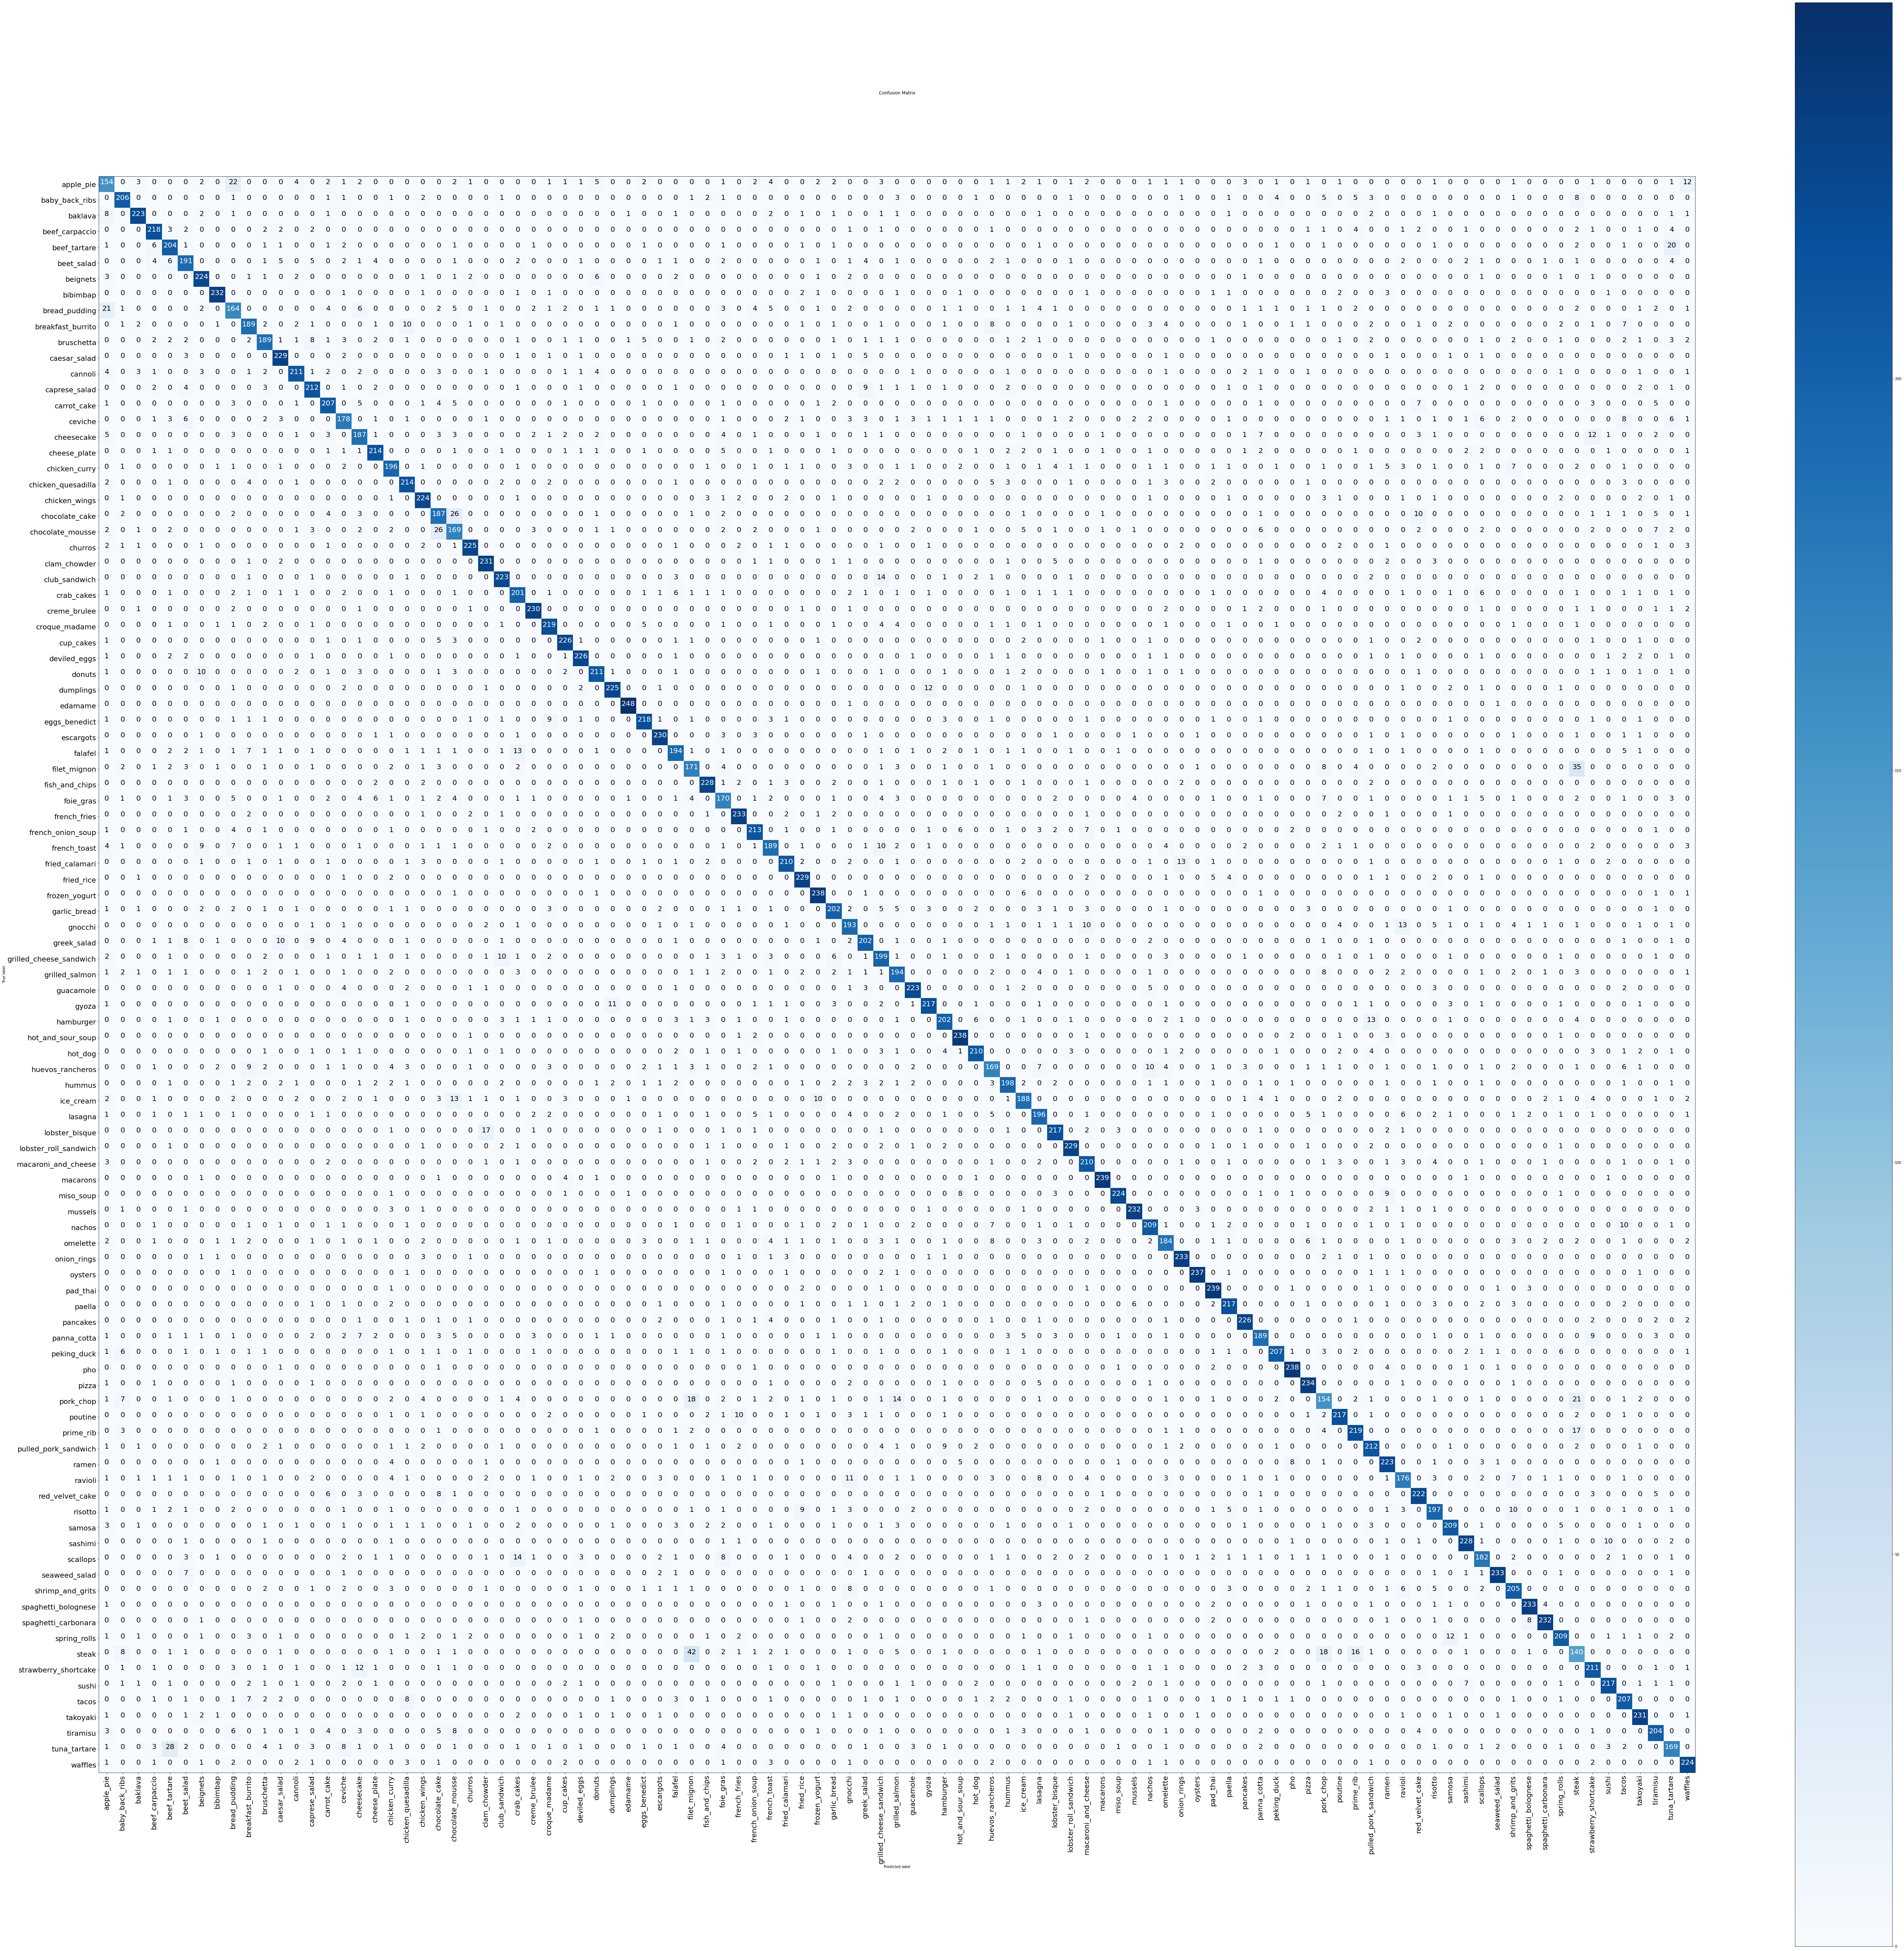

In [ ]:
make_confusion_matrix(y_labels, pred_classes, class_names, (100,100), 20, savefig=True)

## Predicting on Custom Images

In [ ]:
!wget https://raw.githubusercontent.com/r-zeeshan/deep-learning/main/helper_functions.py

--2022-08-22 06:23:40--  https://raw.githubusercontent.com/r-zeeshan/deep-learning/main/my_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12530 (12K) [text/plain]
Saving to: ‘my_helper_functions.py’

my_helper_functions 100%[===================>]  12.24K  --.-KB/s    in 0s      

2022-08-22 06:23:40 (74.7 MB/s) - ‘my_helper_functions.py’ saved [12530/12530]



In [ ]:
from my_helper_functions import load_and_prep_image , pred_and_plot

In [ ]:
import tensorflow as tf
def load_and_prep_image(filename, img_shape=224, scale=False):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img

def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img/255.)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);


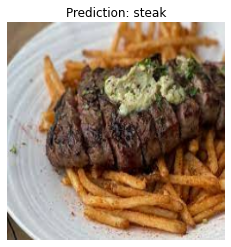

In [ ]:
pred_and_plot(model, "download (10).jpeg", class_names)